In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import Accuracy, AUC, F1Score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries, felzenszwalb

In [2]:
data = pd.read_csv('/kaggle/input/faceexpression-dp/data.csv')
data.head()

,Unnamed: 0,path,label
0,0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


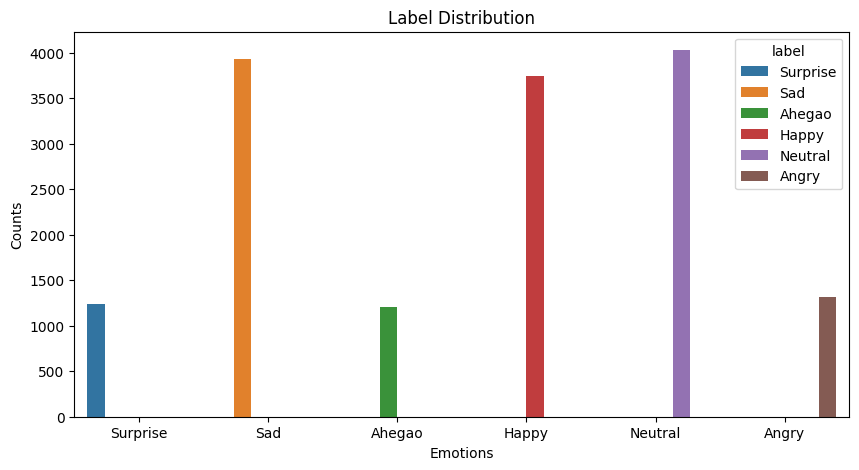

In [3]:
# Getting the label distribution
plt.figure(figsize=(10, 5))
plt.title("Label Distribution")
sns.countplot(data, x='label', hue='label')
plt.xlabel("Emotions")
plt.ylabel("Counts")
plt.show()

In [4]:
# convert the path to full path till the image
image_dir = "/kaggle/input/faceexpression-dp/dataset"

In [5]:
# Define Dataset parameters
TARGET_IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [9]:
image_datagen = ImageDataGenerator(
    rescale = 1./255.,
    validation_split=0.2
)

# Define training dataset
train_datagen = image_datagen.flow_from_directory(
    image_dir,
    target_size = TARGET_IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = 'training',
    shuffle = True
)

# Define testing dataset
test_datagen = image_datagen.flow_from_directory(
    image_dir,
    target_size = TARGET_IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = 'validation',
    shuffle = True
)

class_index = train_datagen.class_indices
index_class = {v:k for k, v in class_index.items()}

Found 12365 images belonging to 6 classes.
Found 3088 images belonging to 6 classes.


(32, 224, 224, 3)


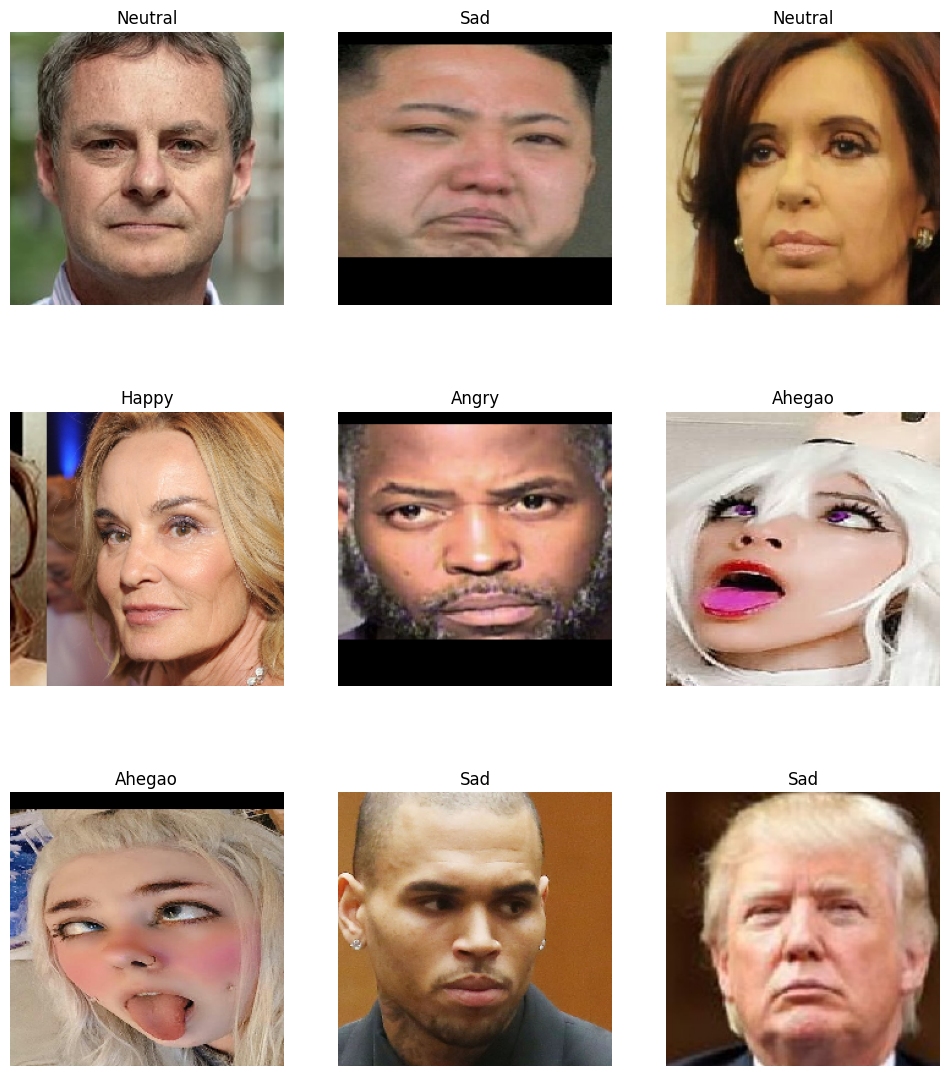

In [10]:
plt.figure(figsize=(12, 14))
for img, label in train_datagen:
    print(img.shape)
    label = np.argmax(label, axis=1)
    
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.title(f"{index_class[label[i]]}")
        plt.imshow(img[i])
        plt.axis('off')
    break

In [6]:
def build_model(img_shape, num_classes, fine_tune = 0, drop_out = 0):
    
#     input_layer = Input(shape=img_shape)
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=img_shape,
    )
    
    # Freeze all the layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Unfreeze certain layers
    if fine_tune != 0:
        for layer in base_model.layers[fine_tune:]:
            layer.trainable = True
    
    
    base_model_output = base_model.output
    
        
    conv1 = Conv2D(1024, kernel_size=3, activation='relu')(base_model_output)
    if drop_out != 0:
        conv1 = Dropout(drop_out)(conv1)
    
    maxpool1 = MaxPooling2D((2, 2))(conv1)
    
    
    x = Flatten()(maxpool1)
    x = Dense(128, activation='relu')(x)
    
    if drop_out != 0:
        x = Dropout(drop_out)(x)
    
    output = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=output)

In [37]:
model = build_model((*TARGET_IMG_SIZE, 3), 6)

In [38]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics = ['accuracy']
)

In [39]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,959,494 (76.14 MB)

 Trainable params: 5,244,806 (20.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [40]:
EPOCHS = 5
history = model.fit(train_datagen, epochs=EPOCHS, validation_data=test_datagen)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/387 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.0000e+00 - auc: 0.5321 - f1_score: 0.0160 - loss: 3.7831    

W0000 00:00:1719767405.663730     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.0000e+00 - auc: 0.8328 - f1_score: 0.4724 - loss: 1.4372

W0000 00:00:1719767476.857037     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


387/387 ━━━━━━━━━━━━━━━━━━━━ 95s 229ms/step - accuracy: 0.0000e+00 - auc: 0.8330 - f1_score: 0.4728 - loss: 1.4361 - val_accuracy: 0.0000e+00 - val_auc: 0.9271 - val_f1_score: 0.6286 - val_loss: 0.8470
Epoch 2/5


W0000 00:00:1719767493.967802     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


387/387 ━━━━━━━━━━━━━━━━━━━━ 84s 214ms/step - accuracy: 0.0000e+00 - auc: 0.9553 - f1_score: 0.7452 - loss: 0.6595 - val_accuracy: 0.0000e+00 - val_auc: 0.9308 - val_f1_score: 0.6412 - val_loss: 0.8592
Epoch 3/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 84s 213ms/step - accuracy: 0.0000e+00 - auc: 0.9763 - f1_score: 0.8290 - loss: 0.4763 - val_accuracy: 0.0000e+00 - val_auc: 0.9330 - val_f1_score: 0.6630 - val_loss: 0.8565
Epoch 4/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 83s 212ms/step - accuracy: 5.0879e-05 - auc: 0.9867 - f1_score: 0.8752 - loss: 0.3573 - val_accuracy: 0.0000e+00 - val_auc: 0.9362 - val_f1_score: 0.6900 - val_loss: 0.8929
Epoch 5/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 85s 218ms/step - accuracy: 5.8582e-04 - auc: 0.9944 - f1_score: 0.9155 - loss: 0.2340 - val_accuracy: 8.6356e-04 - val_auc: 0.9178 - val_f1_score: 0.6500 - val_loss: 1.2047


In [7]:
# Method to plot the train performance
def plot_training_performance(history, metrics):
    plt.figure(figsize=(14, 12))
    
    for i, metrics in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        val_metrics = "val_" + metrics
        
        plt.title(f"{metrics} vs {val_metrics}")
        plt.plot(history.history[metrics], label=metrics)
        plt.plot(history.history[val_metrics], label=val_metrics)
        plt.grid(True)
        plt.xlabel("Epochs")
        plt.ylabel(metrics)
        plt.legend()
    
    plt.show()

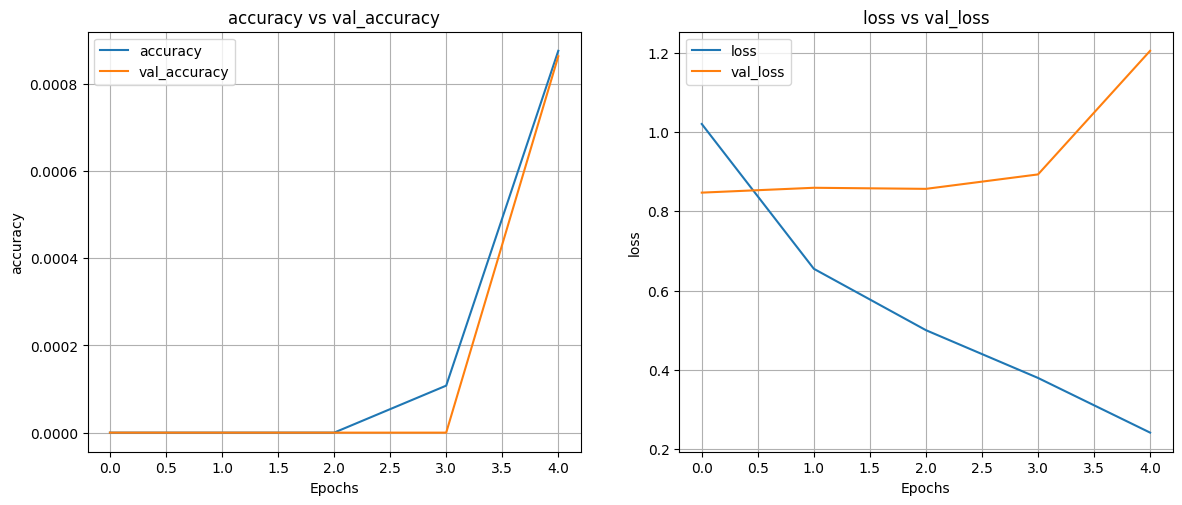

In [46]:
plot_training_performance(history, ['accuracy', 'loss'])

In [8]:
# Method to plot the confusion matrix
def plot_confusion_matrix(conf_mat, labels):
    plt.title("Confusion Matrix", {'size': 16})
    sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Prediction")
    plt.ylabel("True value")
    plt.show()

In [9]:
# Method to plot ROC Curve for Multi-class
def plot_roc_curve(y_true, y_pred, labels):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for idx, label in enumerate(labels):
        fpr[label], tpr[label], _ = roc_curve(y_true[:, idx], y_pred[:, idx])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # PLot the ROC curve
    plt.plot(fpr["micro"], tpr["micro"], label=f"ROC Micro (area = {roc_auc['micro']:.2f})")
    
    for label in labels:
        plt.plot(fpr[label], tpr[label], label=f"ROC for {label} (area = {roc_auc[label]:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label='No Skills')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Face Expressions", {'size': 16})
    plt.legend()

In [10]:
def predictions(model, dataset):
    y_true_proba = []
    y_pred_proba = []
    
    for indx, (img, label) in enumerate(dataset):
        if indx > dataset.num_batches:
            break
        preds = model.predict(img, verbose=0)
        y_true_proba.extend(label)
        y_pred_proba.extend(preds)
    
    y_true_proba = np.array(y_true_proba)
    y_pred_proba = np.array(y_pred_proba)
    
    return (y_true_proba, y_pred_proba)

In [58]:
(train_true_proba, train_pred_proba) = predictions(model, train_datagen)

In [59]:
train_true_label = np.argmax(train_true_proba, axis=1)
train_pred_label = np.argmax(train_pred_proba, axis=1)

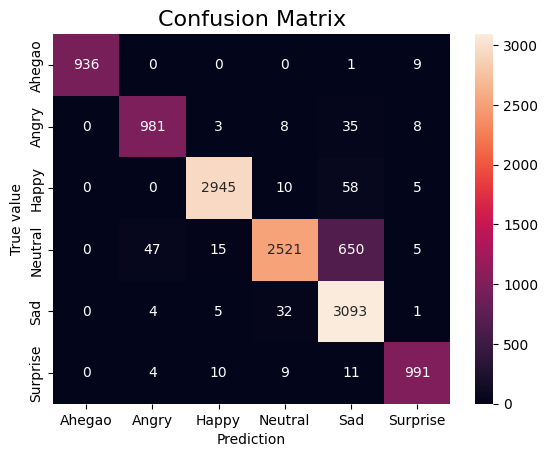

In [71]:
conf_matrix = confusion_matrix(train_true_label, train_pred_label)
labels = list(train_datagen.class_indices.keys())
plot_confusion_matrix(conf_matrix, labels)

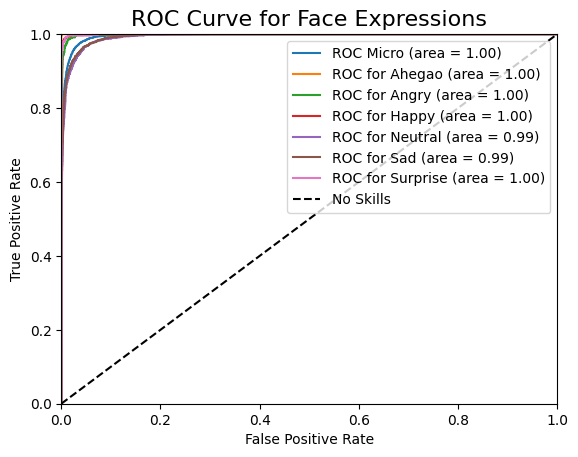

In [72]:
plot_roc_curve(train_true_proba, train_pred_proba, labels)

In [73]:
(test_true_proba, test_pred_proba) = predictions(model, test_datagen)

W0000 00:00:1719769110.228745     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [74]:
test_true_labels = np.argmax(test_true_proba, axis=1)
test_pred_labels = np.argmax(test_pred_proba, axis=1)

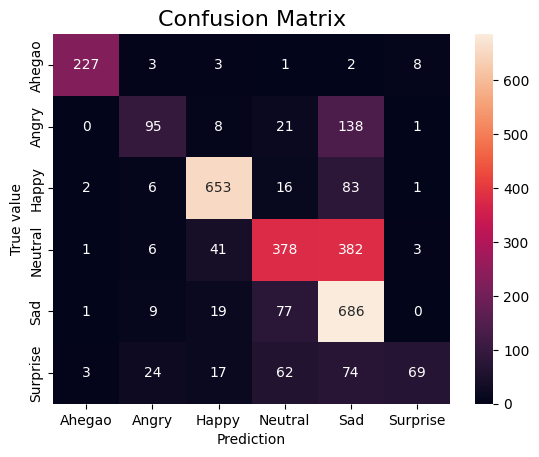

In [75]:
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)
labels = list(test_datagen.class_indices.keys())
plot_confusion_matrix(conf_matrix, labels)

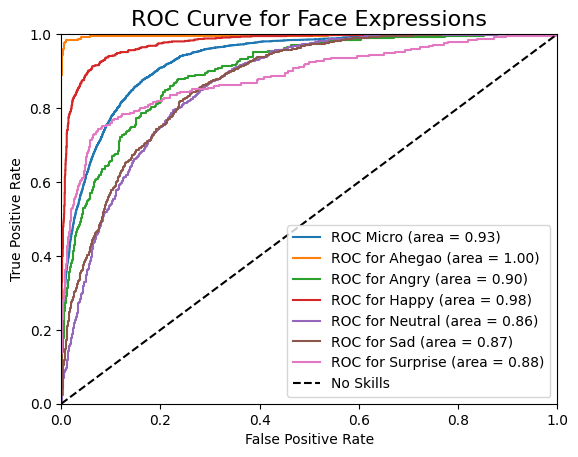

In [76]:
plot_roc_curve(test_true_proba, test_pred_proba, labels)

In [77]:
clf_rprt = classification_report(test_true_labels, test_pred_labels, target_names=labels)
print(clf_rprt)

              precision    recall  f1-score   support

      Ahegao       0.97      0.93      0.95       244
       Angry       0.66      0.36      0.47       263
       Happy       0.88      0.86      0.87       761
     Neutral       0.68      0.47      0.55       811
         Sad       0.50      0.87      0.64       792
    Surprise       0.84      0.28      0.42       249

    accuracy                           0.68      3120
   macro avg       0.76      0.63      0.65      3120
weighted avg       0.72      0.68      0.66      3120



In [123]:
for img, label in test_datagen:
    preds = model.predict(img, verbose=0)
    break

y_true = np.argmax(label, axis=1)
y_pred = np.argmax(preds, axis=1)

In [124]:
explainer = lime_image.LimeImageExplainer()

In [126]:
def predict_proba(img):
    return model.predict(img, verbose=0)

ind = 0
exp_image = img[ind]
exp_true_label = y_true[ind]

img_exp = explainer.explain_instance(
    exp_image,
    predict_proba,
    top_labels = 2,
    hide_color = 0,
    num_samples = 2000,
    segmentation_fn = lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50)
)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [127]:
masks = {}
images = {}
for top_label in img_exp.top_labels:
    img, mask = img_exp.get_image_and_mask(
        top_label,
        positive_only = True,
        num_features = 15,
        hide_rest = True,
    )
    
    masks[top_label] = mask
    images[top_label] = img

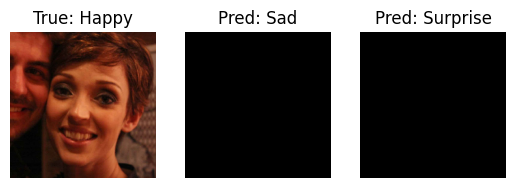

In [128]:
index_class = {v:k for k, v in test_datagen.class_indices.items()}

plt.subplot(1, 3, 1)
plt.imshow(exp_image)
plt.title(f'True: {index_class[exp_true_label]}')
plt.axis('off')

for i, key in enumerate(masks.keys()):
    plt.subplot(1, 3, i+2)
    plt.imshow(mark_boundaries(images[key], mask[key]))
    plt.title(f'Pred: {index_class[key]}')
    plt.axis('off')

The model tends to perform descently well but only thing it lacks at is that it is highly overfiting which needs to be mitigated. We can add dropout to the model thus masking output of layer and we will add augmentation in the dataset to increase the variations which might serve a good starting point to deal with overfitting. From the model interpretation it is seen that the model is not focusing anywhere on the image and making wrong predictions. Hence, it is quite hard to make a qualitative decision from the model interpretation. However, we can atleast start with compensating with overfitting and then we can deal with this issue.

# Finetune 1

In [11]:
image_datagen = ImageDataGenerator(
    rescale = 1./255.,
    validation_split=0.2,
    rotation_range = 45,
    horizontal_flip = True,
    shear_range = 45,
    zoom_range = 0.1
)

# Define training dataset
train_datagen = image_datagen.flow_from_directory(
    image_dir,
    target_size = TARGET_IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = 'training',
    shuffle = True
)

# Define testing dataset
test_datagen = image_datagen.flow_from_directory(
    image_dir,
    target_size = TARGET_IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = 'validation',
    shuffle = True
)

class_index = train_datagen.class_indices
index_class = {v:k for k, v in class_index.items()}

Found 12365 images belonging to 6 classes.
Found 3088 images belonging to 6 classes.


(32, 224, 224, 3)


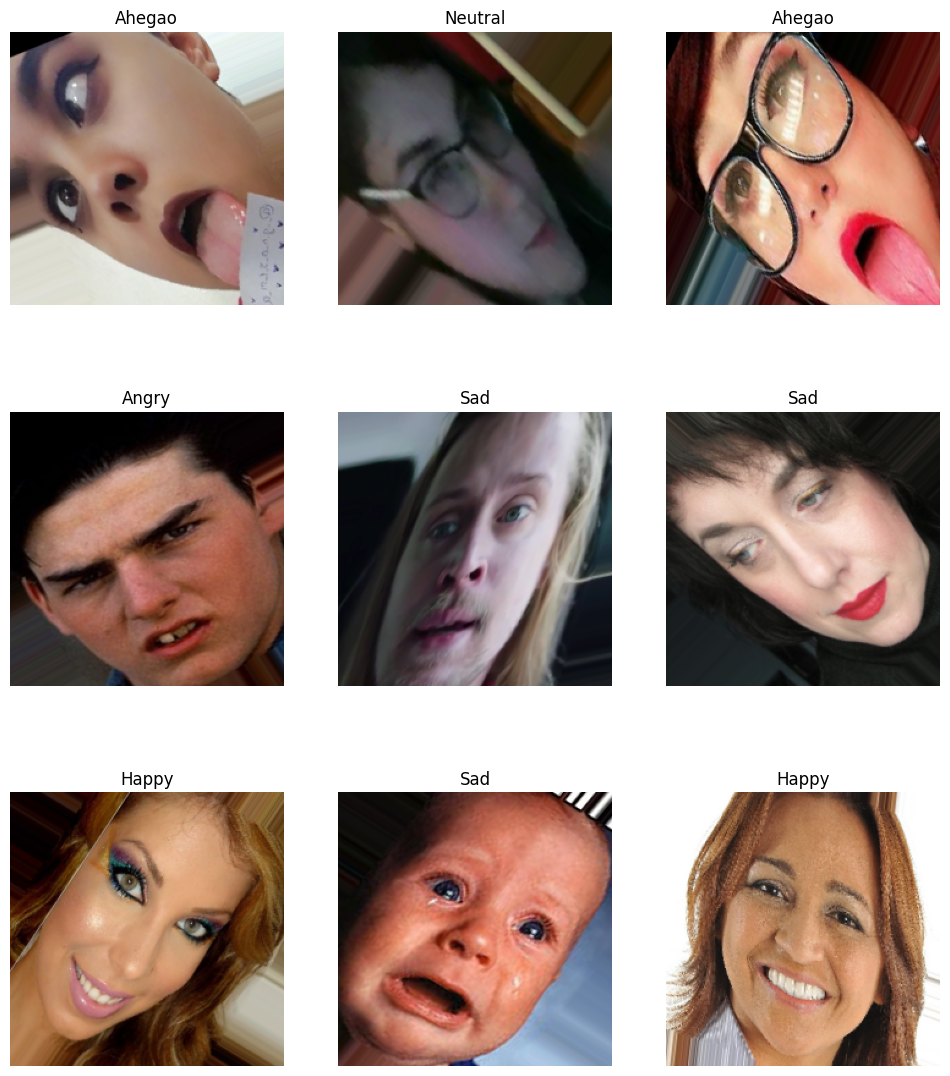

In [12]:
plt.figure(figsize=(12, 14))
for img, label in train_datagen:
    print(img.shape)
    label = np.argmax(label, axis=1)
    
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.title(f"{index_class[label[i]]}")
        plt.imshow(img[i])
        plt.axis('off')
    break

In [15]:
model2 = build_model((*TARGET_IMG_SIZE, 3), 6, drop_out=0.25)

In [16]:
EPOCHS = 20
decay_steps = train_datagen.n * EPOCHS

opt = tf.keras.optimizers.Adam(learning_rate=5e-3)
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = 3e-3,
    decay_steps=decay_steps,
    end_learning_rate = 5e-4,
)

model2.compile(
    loss='categorical_crossentropy', 
    optimizer=opt,
    metrics = ['accuracy']
)

In [17]:
model2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             

 Total params: 19,959,494 (76.14 MB)

 Trainable params: 5,244,806 (20.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
model_checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/model2.keras',
    monitor='val_loss',
    save_best_only = True,
    mode='min',
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience = 5
)

In [19]:
history = model2.fit(
    train_datagen,
    epochs = EPOCHS,
    validation_data = test_datagen,
    callbacks = [model_checkpoint, early_stopping]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-06-30 23:38:32.736351: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-06-30 23:38:32.736405: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-06-30 23:38:32.736422: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-06-30 23:38:32.736436: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-06-30 23:38:32.736445: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

  2/387 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.2266 - loss: 25.5281  

I0000 00:00:1719790730.365144     144 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719790730.386691     144 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


318/387 ━━━━━━━━━━━━━━━━━━━━ 47s 682ms/step - accuracy: 0.3095 - loss: 3.5009

2024-06-30 23:42:28.951287: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 5.04893, expected 4.24247
2024-06-30 23:42:28.951338: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 6.99988, expected 6.19341
2024-06-30 23:42:28.951354: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 6.949, expected 6.14253
2024-06-30 23:42:28.951370: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100355: 6.3455, expected 5.53903
2024-06-30 23:42:28.951384: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100356: 6.4062, expected 5.59973
2024-06-30 23:42:28.951404: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100357: 6.93991, expected 6.13344
2024-06-30 23:42:28.951415: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100358: 5.95738, expected 5.15092
2024-06-30 23:42:28.9514

321/387 ━━━━━━━━━━━━━━━━━━━━ 46s 710ms/step - accuracy: 0.3101 - loss: 3.4854

W0000 00:00:1719790957.333602     144 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.3221 - loss: 3.1980

W0000 00:00:1719791000.736742     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-06-30 23:44:23.940458: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.89842, expected 3.37692
2024-06-30 23:44:23.940516: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13412, expected 2.61262
2024-06-30 23:44:23.940525: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.08377, expected 2.56227
2024-06-30 23:44:23.940533: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.1021, expected 3.5806
2024-06-30 23:44:23.940541: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.76539, expected 3.24388
2024-06-30 23:44:23.940549: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.19841, expected 3.6769
2024-06-30 23:44:23.940557: E external/local_xla/xla/service/gp

387/387 ━━━━━━━━━━━━━━━━━━━━ 371s 888ms/step - accuracy: 0.3223 - loss: 3.1942 - val_accuracy: 0.4900 - val_loss: 1.2669
Epoch 2/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 233s 560ms/step - accuracy: 0.4731 - loss: 1.2976 - val_accuracy: 0.5178 - val_loss: 1.1939
Epoch 3/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 218s 556ms/step - accuracy: 0.5088 - loss: 1.2076 - val_accuracy: 0.5026 - val_loss: 1.2132
Epoch 4/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 218s 557ms/step - accuracy: 0.5288 - loss: 1.1699 - val_accuracy: 0.5198 - val_loss: 1.1827
Epoch 5/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 218s 555ms/step - accuracy: 0.5249 - loss: 1.1634 - val_accuracy: 0.5625 - val_loss: 1.1096
Epoch 6/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 218s 555ms/step - accuracy: 0.5259 - loss: 1.1484 - val_accuracy: 0.5560 - val_loss: 1.1409
Epoch 7/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 219s 557ms/step - accuracy: 0.5361 - loss: 1.1427 - val_accuracy: 0.5547 - val_loss: 1.1682
Epoch 8/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 218s 554ms/step - accuracy: 0.5505 - loss: 1.12

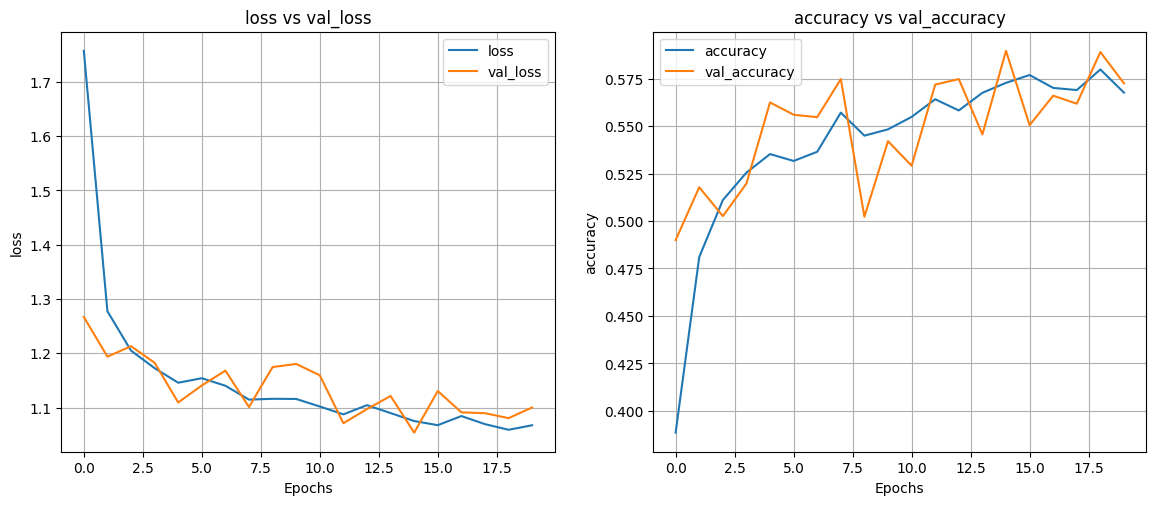

In [20]:
plot_training_performance(history, ['loss', 'accuracy'])

In [21]:
(test_true_proba, test_pred_proba) = predictions(model2, test_datagen)

W0000 00:00:1719795253.837166     144 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [22]:
test_true_labels = np.argmax(test_true_proba, axis=1)
test_pred_labels = np.argmax(test_pred_proba, axis=1)

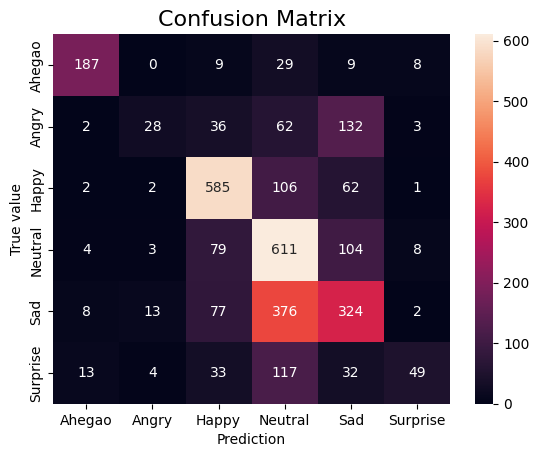

In [23]:
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)
labels = list(class_index.keys())
plot_confusion_matrix(conf_matrix, labels)

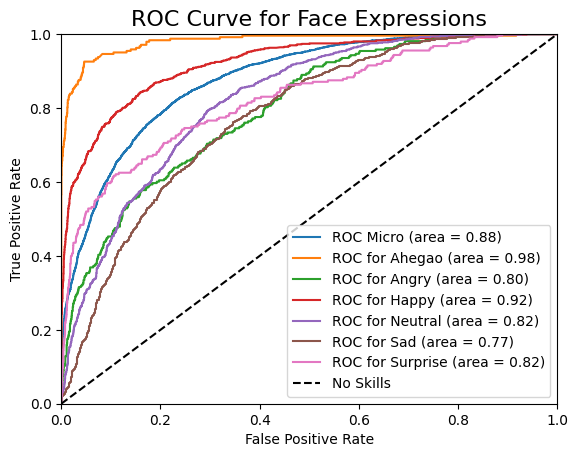

In [24]:
plot_roc_curve(test_true_proba, test_pred_proba, labels)

In [25]:
clf_rprt = classification_report(test_true_labels, test_pred_labels, target_names=labels)
print(clf_rprt)

              precision    recall  f1-score   support

      Ahegao       0.87      0.77      0.82       242
       Angry       0.56      0.11      0.18       263
       Happy       0.71      0.77      0.74       758
     Neutral       0.47      0.76      0.58       809
         Sad       0.49      0.41      0.44       800
    Surprise       0.69      0.20      0.31       248

    accuracy                           0.57      3120
   macro avg       0.63      0.50      0.51      3120
weighted avg       0.59      0.57      0.55      3120



In [52]:
for test_image, label in test_datagen:
    preds = model2.predict(test_image, verbose=0)
    break

y_true = np.argmax(label, axis=1)
y_pred = np.argmax(preds, axis=1)

In [75]:
explainer = lime_image.LimeImageExplainer()

In [76]:
def predict_proba2(imgs):
    imgs = tf.cast(imgs, dtype=tf.float32)
    return model2(imgs).numpy()

ind = 0
exp_image = test_image[ind]
exp_true_label = y_true[ind]

img_exp = explainer.explain_instance(
    exp_image,
    predict_proba2,
    top_labels = 2,
    hide_color = 0,
    num_samples = 2000,
    segmentation_fn = lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50)
)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [77]:
masks = {}
images = {}
for top_label in img_exp.top_labels:
    image, mask = img_exp.get_image_and_mask(
        top_label,
        positive_only = True,
        num_features = 15,
        hide_rest = True,
    )
    
    masks[top_label] = mask
    images[top_label] = image

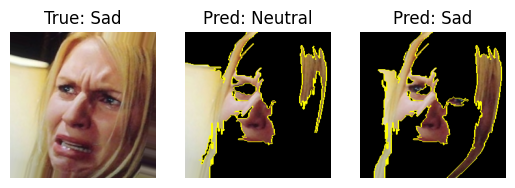

In [78]:
index_class = {v:k for k, v in test_datagen.class_indices.items()}

plt.subplot(1, 3, 1)
plt.imshow(exp_image)
plt.title(f'True: {index_class[exp_true_label]}')
plt.axis('off')

for i, key in enumerate(masks.keys()):
    plt.subplot(1, 3, i+2)
    plt.imshow(mark_boundaries(images[key], masks[key]))
    plt.title(f'Pred: {index_class[key]}')
    plt.axis('off')

The model performance has changed slightly, now it is not overfitting but the model is not acheving any desirable performane even. Also the model misclassifies a lot of Sad image as Neutral which can be seen from the above given model interpretation. Also, it can be seen that for Neutral and Sad it tends to extract a very identical regions of the image and this justifies why it is confused for it. 

Taking the model interpretability and the model's visuals of training it can be concluded that the model is underfitting for which more features needs to be added. Hence we will unfreeze layer(s) from the base model to assist in our task.

# Finetune 2

In [39]:
def build_model2(img_shape, num_classes, fine_tune = 0, drop_out = 0):
    
#     input_layer = Input(shape=img_shape)
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=img_shape,
    )
    
    # Freeze all the layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Unfreeze certain layers
    if fine_tune != 0:
        for layer in base_model.layers[fine_tune:]:
            layer.trainable = True
    
    
    base_model_output = base_model.output
    
        
#     conv1 = Conv2D(1024, kernel_size=3, activation='relu')(base_model_output)
#     if drop_out != 0:
#         conv1 = Dropout(drop_out)(conv1)
    
#     maxpool1 = MaxPooling2D((2, 2))(conv1)
    
    
#     x = Flatten()(maxpool1)
#     x = Dense(512, activation='relu')(x)
    x = GlobalAveragePooling2D()(base_model_output)
    
    x = Dense(1024, activation='relu')(x)
    if drop_out != 0:
        x = Dropout(drop_out)(x)
    
    output = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=output)

In [53]:
model3 = build_model2((*TARGET_IMG_SIZE, 3), 6, drop_out = 0.25)

In [54]:
EPOCHS = 20
decay_steps = train_datagen.n * EPOCHS

opt = tf.keras.optimizers.Adam(learning_rate=5e-3)
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = 3e-3,
    decay_steps=decay_steps,
    end_learning_rate = 5e-4,
)

model3.compile(
    loss='categorical_crossentropy', 
    optimizer=opt,
    metrics = ['accuracy']
)

In [55]:
model3.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 531,462 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [56]:
model_checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/model2.keras',
    monitor='val_loss',
    save_best_only = True,
    mode='min',
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience = 4
)

In [ ]:
history = model3.fit(
    train_datagen,
    epochs = EPOCHS,
    validation_data = test_datagen,
    callbacks = [model_checkpoint, early_stopping]
)

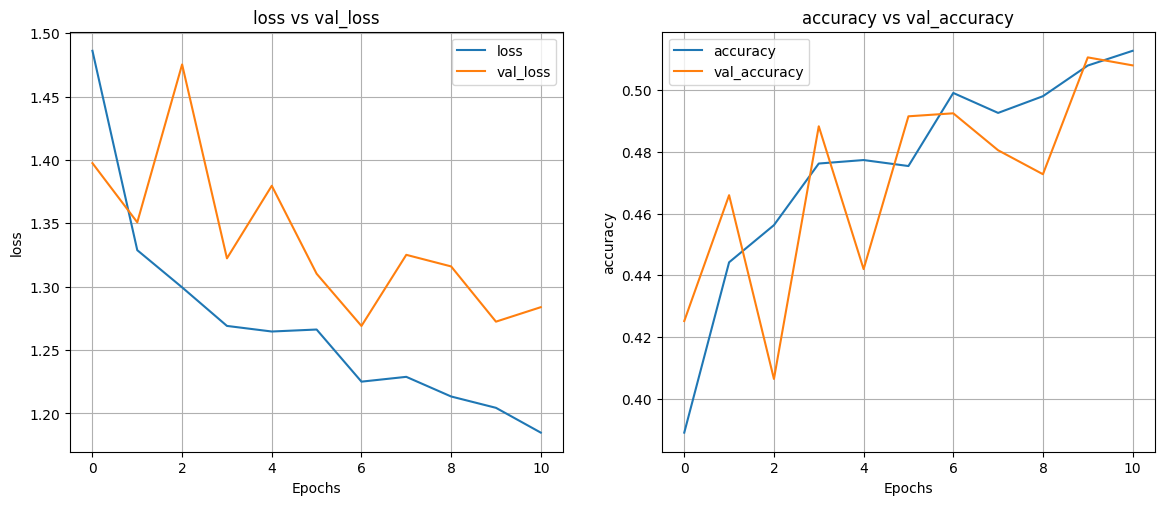

In [19]:
plot_training_performance(history, ['loss', 'accuracy'])

In [20]:
(test_true_proba, test_pred_proba) = predictions(model3, test_datagen)

In [21]:
test_true_labels = np.argmax(test_true_proba, axis=1)
test_pred_labels = np.argmax(test_pred_proba, axis=1)

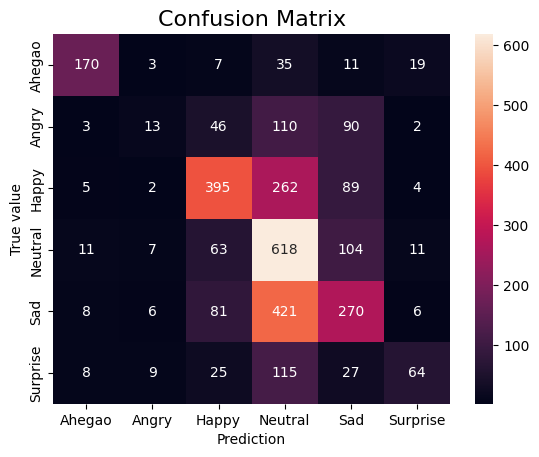

In [22]:
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)
labels = list(class_index.keys())
plot_confusion_matrix(conf_matrix, labels)

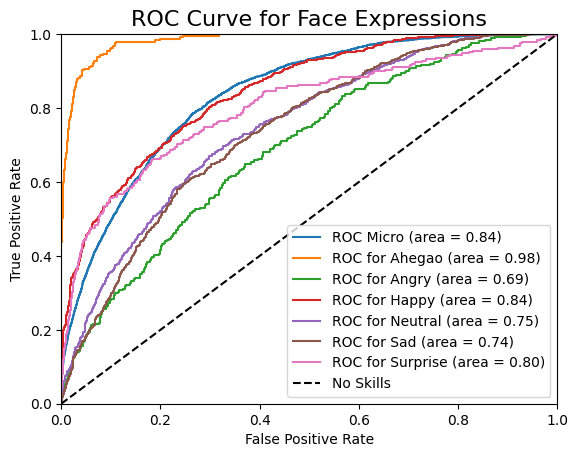

In [23]:
plot_roc_curve(test_true_proba, test_pred_proba, labels)

In [24]:
clf_rprt = classification_report(test_true_labels, test_pred_labels, target_names=labels)
print(clf_rprt)

              precision    recall  f1-score   support

      Ahegao       0.83      0.69      0.76       245
       Angry       0.33      0.05      0.09       264
       Happy       0.64      0.52      0.57       757
     Neutral       0.40      0.76      0.52       814
         Sad       0.46      0.34      0.39       792
    Surprise       0.60      0.26      0.36       248

    accuracy                           0.49      3120
   macro avg       0.54      0.44      0.45      3120
weighted avg       0.52      0.49      0.47      3120



In [26]:
for test_image, label in test_datagen:
    preds = model3.predict(test_image, verbose=0)
    break

y_true = np.argmax(label, axis=1)
y_pred = np.argmax(preds, axis=1)

In [27]:
explainer = lime_image.LimeImageExplainer()

In [31]:
def predict_proba3(imgs):
    imgs = tf.cast(imgs, dtype=tf.float32)
    return model3(imgs).numpy()

ind = 10
exp_image = test_image[ind]
exp_true_label = y_true[ind]

img_exp = explainer.explain_instance(
    exp_image,
    predict_proba3,
    top_labels = 2,
    hide_color = 0,
    num_samples = 2000,
    segmentation_fn = lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50)
)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [32]:
masks = {}
images = {}
for top_label in img_exp.top_labels:
    image, mask = img_exp.get_image_and_mask(
        top_label,
        positive_only = True,
        num_features = 15,
        hide_rest = True,
    )
    
    masks[top_label] = mask
    images[top_label] = image

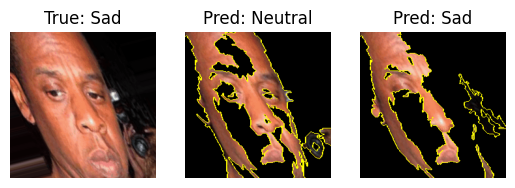

In [33]:
index_class = {v:k for k, v in test_datagen.class_indices.items()}

plt.subplot(1, 3, 1)
plt.imshow(exp_image)
plt.title(f'True: {index_class[exp_true_label]}')
plt.axis('off')

for i, key in enumerate(masks.keys()):
    plt.subplot(1, 3, i+2)
    plt.imshow(mark_boundaries(images[key], masks[key]))
    plt.title(f'Pred: {index_class[key]}')
    plt.axis('off')

Even after adding more layers the model does not tend to correctly identify the emotions in the Images. A probable cause for this could be

1. The base model VGG is trained on ImageNet which is a more general dataset that represent all objects where image of faces has comparitively more complex features.

2. Wider feature space. The dataset is more complex than the model and its pretrained dataset.